In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter

from tensorflow_addons.losses import WeightedKappaLoss
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, DenseNet169, ResNet50V2
from tensorflow.keras.applications import densenet, resnet50, vgg16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import Model

from munch import DefaultMunch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.keras import WandbCallback

from datasets import load_MURA

# Configuration

In [ ]:
# Configuration object
config_dic={
        "architecture": "ResNet50", # options are [VGG16, ResNet50, DenseNet121, DenseNet169]
        "dataset": "mura",
        "body_part": [], # create array of body parts, which you want to include e.g.: ["XR_WRIST", "XR_ELBOW"]. Leave empty, if you want all data
        "image_resolution": 224,
        "epochs": 30,
        "batch_size": 64,
        "loss_function": "binary_crossentropy",
        "learning_rate": 0.0001,
        "validation_split": 0.2,
        "side note": "First hopefully working well test."
    }

config = DefaultMunch.fromDict(config_dic)

img_size = config.image_resolution

In [ ]:
wandb.login

run = wandb.init(project="CNN_project", entity="techvo", config=config_dic)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


KernelInterrupted: Execution interrupted by the Jupyter kernel.

# Setup model

In [ ]:
model = {
        "VGG16": VGG16,
        "ResNet50": ResNet50,
        "DenseNet121": DenseNet121,
        "DenseNet169": DenseNet169,
        "ResNet50V2": ResNet50V2
        }
preprocessing_function = {
                            "VGG16": vgg16.preprocess_input,
                            "DenseNet169": densenet.preprocess_input,
                            "DenseNet121": densenet.preprocess_input,
                            "ResNet50": resnet50.preprocess_input
}

base_model = model[config.architecture](input_shape=(img_size, img_size, 3),
                                        weights='imagenet',
                                        include_top=False,
                                        pooling='max' )

head_model = base_model.layers[-1].output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(1, activation="sigmoid")(head_model)

final_model = Model(inputs=[base_model.inputs], outputs=[head_model])


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
final_model.compile(
                optimizer=tf.keras.optimizers.Adam(config.learning_rate), 
                loss=config.loss_function,
                metrics=['accuracy', 'mse'])

# Load data

In [ ]:
main_dir = "/root/work/CNN_from_scratch/data/"
csv_dir = "/root/work/CNN_from_scratch/data/MURA-v1.1/"

df_o = pd.read_csv(csv_dir+"train_image_data.csv",names=["path","label"], skiprows=1)
df_o =  df_o.astype({'path': str, 'label': str})
df_o

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0


## pick specific body part

In [ ]:
pattern = '|'.join(config.body_part)

df = df_o[df_o['path'].str.contains(pattern)]

## shuffle rows in dataframe

In [ ]:
df = df.sample(frac=1.).reset_index(drop=True)
df

,path,label
0,MURA-v1.1/train/XR_WRIST/patient07013/study1_p...,1
1,MURA-v1.1/train/XR_WRIST/patient07770/study1_n...,0
2,MURA-v1.1/train/XR_ELBOW/patient05184/study1_p...,1
3,MURA-v1.1/train/XR_WRIST/patient06914/study1_p...,1
4,MURA-v1.1/train/XR_HAND/patient10689/study1_ne...,0
...,...,...
36803,MURA-v1.1/train/XR_ELBOW/patient06298/study1_n...,0
36804,MURA-v1.1/train/XR_FINGER/patient04742/study1_...,0
36805,MURA-v1.1/train/XR_WRIST/patient07266/study1_p...,1
36806,MURA-v1.1/train/XR_HAND/patient01159/study1_ne...,0


In [ ]:
np.unique(list(df['label']))

array(['0', '1'], dtype='<U1')

# Set up Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range= 30 ,
    horizontal_flip= True,
    fill_mode="constant",
    validation_split=0.2,
    preprocessing_function = preprocessing_function[config.architecture]
)

train_generator = datagen.flow_from_dataframe(
                                        df,
                                        directory=main_dir,
                                        x_col="path",
                                        y_col="label",
                                        target_size=(img_size,img_size),
                                        color_mode="rgb",
                                        class_mode="binary",
                                        batch_size= config.batch_size,
                                        subset='training',
                                        shuffle=True
                                        )

validation_generator = datagen.flow_from_dataframe(
                                        df,
                                        directory=main_dir,
                                        x_col="path",
                                        y_col="label",
                                        target_size=(img_size,img_size),
                                        color_mode="rgb",
                                        class_mode="binary",
                                        batch_size= config.batch_size,
                                        subset='validation',
                                        shuffle=True
                                        )

Found 29447 validated image filenames belonging to 2 classes.
Found 7361 validated image filenames belonging to 2 classes.


# Calculate weights

In [ ]:
counter = Counter(train_generator.classes)                          

total =  counter[0] + counter[1]

weight_for_1 = counter[0] / total
weight_for_0 = counter[1] / total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.40
Weight for class 1: 0.60


In [ ]:
class_weight

{0: 0.4031650083200326, 1: 0.5968349916799675}

# Setup callbacks

In [ ]:
callbacks = [
    WandbCallback(),
    EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", min_delta=0.0001, factor=0.1, patience=1, mode="min", verbose=1)
]

# Fit model

In [ ]:
history = final_model.fit(
                    train_generator,
                    validation_data=validation_generator,
                    epochs=config.epochs,
                    class_weight=class_weight,
                    callbacks=callbacks
                    )

Epoch 1/30
461/461 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.6694 - mse: 0.2410/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
461/461 [==============================] - 830s 2s/step - loss: 0.4408 - accuracy: 0.6694 - mse: 0.2410 - val_loss: 0.5321 - val_accuracy: 0.7409 - val_mse: 0.1767 - _timestamp: 1650900497.0000 - _runtime: 883.0000 - lr: 1.0000e-04
Epoch 2/30
461/461 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.7548 - mse: 0.1689
Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
461/461 [==============================] - 984s 2s/step - loss: 0.2486 - accuracy: 0.7548 - mse: 0.1689 - val_loss: 0.5623 - val_accuracy: 0.7182 - val_mse: 0.1889 - _timestamp: 16509015

Exception: The wandb backend process has shutdown

Exception: The wandb backend process has shutdown

# Evaluate model

In [ ]:
df_test = pd.read_csv(csv_dir+"valid_image_data.csv",names=["path","label"], skiprows=1)
df_test = df_test.astype('string')

df_test = df_test[df_test['path'].str.contains(pattern)]
df_test

,path,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,0


In [ ]:
datagen_test = ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
test_generator = datagen_test.flow_from_dataframe(
                    df_test,
                    directory=main_dir,
                    x_col="path",
                    y_col="label",
                    target_size=(img_size, img_size),
                    class_mode='binary',
                    color_mode='rgb',
                    shuffle=False,
                )

Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
score = final_model.evaluate(test_generator, verbose=1)
test_generator.reset()

y_prediction = final_model.predict(test_generator)
y_pred = y_prediction.copy()
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

100/100 [==============================] - 32s 302ms/step - loss: 0.4675 - accuracy: 0.8029 - mse: 0.1456


In [ ]:
y_test = list(df_test['label'].astype(int))

In [ ]:
kap = cohen_kappa_score(y_test , y_pred)
print(str(kap))

0.6018188805830287


<AxesSubplot:>

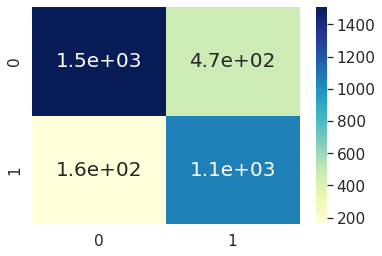

In [ ]:
cm = confusion_matrix(y_pred, y_test)
import seaborn as sn
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=64d23a20-b5bc-41cc-930c-3bd7ede12b0c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>